# Day 6：合并、分组与小型流程项目（串联前五天）

> 今日目标：掌握表合并 (merge / concat) 与分组聚合 (groupby + agg)，完成一个迷你分析闭环：提出问题 → 处理 → 结果图表 → 简短结论。

学习路径：
1. 准备数据集介绍
2. 合并 merge 基本用法 (one-to-one / many-to-one)
3. concat 纵向拼接
4. groupby 分组聚合与多指标 agg
5. 新增衍生指标 (人均/差值)
6. Mini Project 任务说明
7. 项目示例骨架 (可直接改)
8. 小结
9. 课后作业要求

## 1. 准备数据集
我们将使用：
- `air_quality_timeseries.csv` (Day4/5 见过)
- `city_info.csv` ：包含城市人口 (百万) / 行政区域 (region) / 面积 (km²)
目标：合并后计算 *人均 PM2.5* / 区域对比 / 排名。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

air = pd.read_csv('../data/air_quality_timeseries.csv', parse_dates=['date'])
info = pd.read_csv('../data/city_info.csv')
air.head()

,date,city,province,PM25,PM10,NO2,SO2
0,2025-09-01,广州,广东,42,55,19,7
1,2025-09-02,广州,广东,41,54,18,7
2,2025-09-03,广州,广东,39,50,17,6
3,2025-09-04,广州,广东,45,57,20,7
4,2025-09-05,广州,广东,44,56,19,7


In [2]:
info.head()

,city,province,region,population_million,area_km2
0,广州,广东,华南,18.7,7434
1,深圳,广东,华南,17.9,1997
2,佛山,广东,华南,9.7,3848
3,北京,北京,华北,21.9,16411
4,上海,上海,华东,25.0,6341


## 2. merge 合并基础
常见：`pd.merge(left, right, on='key', how='inner')`。
how 取值：inner / left / right / outer。今天主要用 inner 或 left。
键：城市 city。

In [3]:
merged = pd.merge(air, info, on='city', how='left')
merged.head()

,date,city,province_x,PM25,PM10,NO2,SO2,province_y,region,population_million,area_km2
0,2025-09-01,广州,广东,42,55,19,7,广东,华南,18.7,7434
1,2025-09-02,广州,广东,41,54,18,7,广东,华南,18.7,7434
2,2025-09-03,广州,广东,39,50,17,6,广东,华南,18.7,7434
3,2025-09-04,广州,广东,45,57,20,7,广东,华南,18.7,7434
4,2025-09-05,广州,广东,44,56,19,7,广东,华南,18.7,7434


In [4]:
print('合并后形状:', merged.shape)
print('列名:', merged.columns.tolist())
print('是否存在缺失:')
print(merged.isnull().sum())

合并后形状: (30, 11)
列名: ['date', 'city', 'province_x', 'PM25', 'PM10', 'NO2', 'SO2', 'province_y', 'region', 'population_million', 'area_km2']
是否存在缺失:
date                  0
city                  0
province_x            0
PM25                  0
PM10                  0
NO2                   0
SO2                   0
province_y            0
region                0
population_million    0
area_km2              0
dtype: int64


### 小练习 1
1. 如果想只保留在 city_info 中出现的城市，应使用哪种 how？
2. 如果想保留全部城市 + 标记未匹配项？

## 3. concat 纵向拼接
场景：多文件同结构追加。例如将前 3 天与后 2 天拆分再合并。

In [5]:
part1 = air[air['date'] <= air['date'].sort_values().unique()[2]]
part2 = air[air['date'] > air['date'].sort_values().unique()[2]]
recombined = pd.concat([part1, part2], axis=0)
print('是否一样:', recombined.shape == air.shape)
recombined.head()

是否一样: True


,date,city,province,PM25,PM10,NO2,SO2
0,2025-09-01,广州,广东,42,55,19,7
1,2025-09-02,广州,广东,41,54,18,7
2,2025-09-03,广州,广东,39,50,17,6
5,2025-09-01,北京,北京,60,80,35,12
6,2025-09-02,北京,北京,65,85,37,13


### 小练习 2
1. 模拟一个缺少某列的 DataFrame 再 concat，观察列对齐。
2. axis=1 会发生什么？

## 4. groupby 分组聚合与多指标 agg
示例：按城市统计 PM2.5 平均值 & 最大值；按区域统计 PM2.5/PM10 平均。

In [6]:
# 每城市 PM2.5 平均与最大
city_pm25_stats = merged.groupby('city')['PM25'].agg(['mean','max','min']).sort_values('mean', ascending=False)
city_pm25_stats.head()

,mean,max,min
city,,,
北京,62.2,66,58
成都,59.2,62,57
重庆,55.4,57,54
上海,45.0,47,43
广州,42.2,45,39


In [7]:
# 按区域 region 计算 PM2.5 & PM10 平均
region_stats = merged.groupby('region')[['PM25','PM10']].mean().sort_values('PM25', ascending=False)
region_stats

,PM25,PM10
region,,
华北,62.2,82.2
西南,57.3,74.3
华南,42.2,54.4
华东,42.0,56.0


### 多列不同聚合写法
`agg({'PM25':['mean','max'], 'PM10':'mean'})`

In [8]:
multi_agg = merged.groupby('region').agg({'PM25':['mean','max'], 'PM10':'mean'})
multi_agg

PM25      PM10
        mean max  mean
region                
华东      42.0  47  56.0
华北      62.2  66  82.2
华南      42.2  45  54.4
西南      57.3  62  74.3

### 小练习 3
1. 计算各 city 的 NO2 平均与 SO2 平均。
2. 找出平均 PM25 最低的 3 个城市。

## 5. 新增衍生指标 (人均 & 比值)
示例：人均 PM2.5 = PM25 / population_million (注意只是示例，并非真实科学算法)。
还可构造：PM10 与 PM25 之差 diff = PM10 - PM25。

In [9]:
merged['PM25_per_million'] = merged['PM25'] / merged['population_million']
merged['PM_diff'] = merged['PM10'] - merged['PM25']
merged[['date','city','PM25','population_million','PM25_per_million','PM_diff']].head()

,date,city,PM25,population_million,PM25_per_million,PM_diff
0,2025-09-01,广州,42,18.7,2.245989,13
1,2025-09-02,广州,41,18.7,2.192513,13
2,2025-09-03,广州,39,18.7,2.085561,11
3,2025-09-04,广州,45,18.7,2.406417,12
4,2025-09-05,广州,44,18.7,2.352941,12


In [10]:
# 区域层面的人均 PM2.5 平均 (再聚合)
region_per_capita = merged.groupby('region')['PM25_per_million'].mean().sort_values(ascending=False)
region_per_capita

region
华北    2.840183
华东    2.460000
西南    2.272452
华南    2.256684
Name: PM25_per_million, dtype: float64

### 小练习 4
1. 新增列 PM_ratio = PM10 / PM25。
2. 计算各区域 PM_ratio 平均，排序。

## 6. Mini Project 任务说明
30~45 分钟内完成：
1. 选 2~3 个问题 (例：哪个区域人均 PM2.5 指标最高？城市 PM10-PM25 差值分布怎样？)
2. 数据流程：读取 → 合并 → 衍生列 → 分组统计/排序 → 1 张图 (柱状/折线/散点选其一)
3. 输出：
   - 关键表 1~2 个 (head 或整表简洁显示)
   - 图 1 张
   - 结论 80~120 字（含客观描述 + 解释 + 局限）
4. 伦理：注明数据来源 (课程提供示例)

## 7. 项目示例骨架 (可直接复制修改)
下面示例：问题：哪个区域的平均 PM25 与人均 PM25 指标都偏高？

In [11]:
# (1) 基础汇总
region_summary = merged.groupby('region').agg({
    'PM25':'mean',
    'PM25_per_million':'mean',
    'PM_diff':'mean'
}).sort_values('PM25', ascending=False)
region_summary

,PM25,PM25_per_million,PM_diff
region,,,
华北,62.2,2.840183,20.0
西南,57.3,2.272452,17.0
华南,42.2,2.256684,12.2
华东,42.0,2.460000,14.0


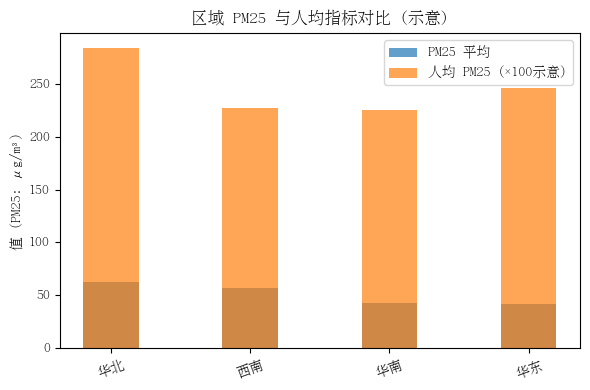

In [19]:
# (2) 可视化：区域 PM25 & 人均 PM25 对比 (双柱简单示意)

# 设置中文显示和负号正常显示
plt.rcParams['font.sans-serif'] = ['AR PL UMing CN']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(6,4))
x = region_summary.index
plt.bar(x, region_summary['PM25'], width=0.4, alpha=0.7, label='PM25 平均')

plt.bar(x, region_summary['PM25_per_million']*100, width=0.4, alpha=0.7, label='人均 PM25 (×100示意)')
plt.title('区域 PM25 与人均指标对比 (示意)')
plt.ylabel('值 (PM25: μg/m³)')
plt.xticks(rotation=20)
plt.legend()
plt.tight_layout()
plt.show()

> 说明：人均指标乘以 100 只是为了放在同一尺度上做演示，真实比较应规范化或用双轴 (本课程暂不展开)。

### 示例结论草稿 (请自行再加工)
华南与西南区域 PM25 平均值位于前列，同时人均 PM25 示意指标（缩放后）也较高，说明这些区域内人口集中城市的空气质量治理仍需关注。需要注意样本仅 5 天，且指标简化，不代表长期趋势。

### 小练习 5
1. 选取 PM_diff 最大的前 5 个城市，看看是否集中在某区域。
2. 重新绘制一张图：只展示 top5 城市的 PM25 平均值。
3. 写 2 句说明该图表达了什么。

## 8. 小结
今日串联：
1. merge：按 key（city）横向引入维度信息；how 影响保留范围（inner/left 等）。
2. concat：纵向追加同结构数据，注意列自动对齐与缺失填补。
3. groupby + agg：支持多指标统计，形成结构化摘要；链式：排序→筛选→可视化。
4. 衍生指标：基于领域/问题设计（人均、差值、比率）→ 先说明计算假设。
5. Mini Project：强调“问题驱动”而非“函数堆砌”。

实务建议：
- 每做一次合并后立即 shape / isnull().sum() 自检。
- 聚合输出命名清晰（mean / max），必要时 reset_index 方便后续处理。
- 指标缩放或示意需注明倍数，保持透明与可复现。

衔接：明天的入门模型会利用今天的“整洁 + 衍生”思路构造特征。

In [13]:
# 进阶合并与分组示例
import pandas as pd
air = pd.read_csv('../data/air_quality_timeseries.csv', parse_dates=['date'])
info = pd.read_csv('../data/city_info.csv')

# 1. 合并并带来源指示
m = pd.merge(air, info, on='city', how='left', indicator=True)
print(m['_merge'].value_counts())

# 2. 多级 agg 扁平化
agg_df = m.groupby('region').agg({'PM25':['mean','max'], 'PM10':'mean'})
agg_df.columns = ['_'.join(col) for col in agg_df.columns]
print(agg_df.head())

# 3. 分组排名
m['PM25_rank_in_city'] = m.groupby('city')['PM25'].rank(ascending=False, method='dense')
print(m[['city','date','PM25','PM25_rank_in_city']].head())

# 4. 透视表雏形
pivot = m.pivot_table(values='PM25', index='region', columns='date', aggfunc='mean')
print(pivot.head())

# 5. 分组过滤：只保留记录数>=5 的城市
filtered = m.groupby('city').filter(lambda d: len(d) >= 5)
print('过滤后城市数:', filtered['city'].nunique())

_merge
both          30
left_only      0
right_only     0
Name: count, dtype: int64
        PM25_mean  PM25_max  PM10_mean
region                                
华东           42.0        47       56.0
华北           62.2        66       82.2
华南           42.2        45       54.4
西南           57.3        62       74.3
  city       date  PM25  PM25_rank_in_city
0   广州 2025-09-01    42                3.0
1   广州 2025-09-02    41                4.0
2   广州 2025-09-03    39                5.0
3   广州 2025-09-04    45                1.0
4   广州 2025-09-05    44                2.0
date    2025-09-01  2025-09-02  2025-09-03  2025-09-04  2025-09-05
region                                                            
华东            41.5        43.5        41.0        41.5        42.5
华北            60.0        65.0        58.0        62.0        66.0
华南            42.0        41.0        39.0        45.0        44.0
西南            56.5        55.5        58.0        59.5        57.0
过滤后城市数: 6


### 合并 / 分组进阶技巧
1. 验证连接是否丢数据：合并前后行数 + 是否出现空值。
2. 指定左右键不同名：pd.merge(a,b,left_on='city', right_on='city_name')。
3. 指定多键：on=['date','city']，确保业务唯一。
4. 指标扁平化：multi_agg.columns = ['_'.join(col)] 去除多级列。
5. 分组过滤：groupby('city').filter(lambda d: len(d)>3)。
6. 分组排名：merged['pm25_rank_city'] = merged.groupby('city')['PM25'].rank(ascending=False)。
7. 高效统计唯一个数：nunique(dropna=False)。
8. 交叉表/透视需求起点：merged.pivot_table(values='PM25', index='region', columns='date', aggfunc='mean') (了解)。
9. 丢失键分析：使用 indicator=True 查看合并来源。
10. 内存友好：只选用必要列再合并，减少宽表。

## 9. 课后作业要求
提交 *mini_project_day6.ipynb*：
1. 标题：你的项目主题
2. 至少 2 个明确分析问题 (问题句式)
3. 数据步骤：读取→合并→新增列→分组→图表 (每步有 Markdown 注释)
4. 结果：1~2 张图 + 关键表
5. 结论：100~150 字（含发现 + 局限 + 后续可以加的数据）
6. 伦理与来源：写出数据来源与是否做过简化/假设
(可选) 7. 将其中一段重复统计封装成函数 (如：传入 region 返回其 PM25 均值)。

---
📌 提示：明天 Day 7 只做最小模型体验，保持 Notebook 干净结构利于后续复用。